## 代辦事項：

In [1]:
# 導入模塊
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import sqlite3
import sys
import datetime
import math
sys.path.append('..')
# silence warnings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
# sns.set(font='Taipei Sans TC Beta')

# 自定義模塊
import util.swingTrade as st

In [2]:
pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 150)

# 要導入的資料

In [3]:
df = st.getFullData(startDate='2015-01-01', columns=['成交值(千元)', '流通在外股數(千股)'])

# 處理未導入條件

## 價量

In [4]:

try:
    df['K棒收點'] = (df['收盤價(元)'] - df['最低價(元)']) / (df['最高價(元)'] - df['最低價(元)'])
    df['開盤價(元)'] = df['開盤價(元)'][df['開盤價(元)'] != 'N.A.']
    df['本益比-TEJ'] = df['本益比-TEJ'][df['本益比-TEJ'] != 'N.A.']
    df['開盤價(元)'] = pd.to_numeric(df['開盤價(元)'])
    df['本益比-TEJ'] = pd.to_numeric(df['本益比-TEJ'])
    df['年月日'] = pd.to_datetime(df['年月日'] )
    df['當沖收益'] = ((df['收盤價(元)'] - df['開盤價(元)']) / df['收盤價(元)'])
    df = df.set_index(['年月日', '證券代碼'])
    df['漲跌幅'] = df.groupby('證券代碼')['收盤價(元)'].pct_change() * 100
    df['開收比'] = (df['收盤價(元)'] - df['開盤價(元)']) / df['開盤價(元)'] * 100
    df['成交值等級'] = df.groupby('年月日')['成交值(千元)'].rank(ascending=False)
    df = df[~df.index.duplicated()]
except Exception as e :
    print(e)

df

index    開盤價(元)    最高價(元)    最低價(元)    收盤價(元)  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥   1637541.0   23.9737   23.9737   23.6422   23.7527   
           1102 亞泥   1637542.0   27.1345   27.1345   26.5765   26.6811   
           1103 嘉泥   1637543.0   10.7080   10.7836   10.5188   10.7836   
           1104 環泥   1637544.0   17.2562   17.2894   17.0234   17.2894   
           1108 幸福   1637545.0    7.7999    7.9135    7.7620    7.8756   
...                        ...       ...       ...       ...       ...   
2022-02-11 9951 皇田         NaN   76.8000   76.9000   75.7000   75.8000   
           9955 佳龍         NaN   17.0500   17.1000   16.9500   16.9500   
           9958 世紀鋼        NaN  111.0000  112.5000  111.0000  111.5000   
           9960 邁達康        NaN   26.6500   26.6500   26.6500   26.6500   
           9962 有益         NaN   16.6000   16.9500   16.6000   16.7000   

                     成交量(千股)  成交值(千元)    報酬率％    週轉率％  流通在外股數(千股)  市值(百萬元)  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥      2842   122244 -0.9217  0.0770     3692175   158763   
           1102 亞泥      2967   113776 -1.9231  0.0883     3361447   128575   
           1103 嘉泥       587     8256  0.7067  0.0756      776828    11069   
           1104 環泥       415    10709  0.7752  0.0674      615969    16015   
           1108 幸福       248     2577  0.9709  0.0613      404738     4209   
...                      ...      ...     ...     ...         ...      ...   
2022-02-11 9951 皇田       122     9314 -1.4304  0.1629       74900     5677   
           9955 佳龍        56      969 -0.5865  0.0543      103208     1749   
           9958 世紀鋼      992   110790 -0.4464  0.4283      231639    25828   
           9960 邁達康        1       27  0.1880  0.0030       33593      895   
           9962 有益       429     7181 -0.5952  0.4755       90220     1507   

                     最後揭示買價  最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  \
年月日        證券代碼                                                                
2015-01-05 1101 台泥    43.00   43.10 -0.9259  0.592   0.170     1489    14.88   
           1102 亞泥    38.25   38.45 -1.9418  0.479   0.158     1621    13.91   
           1103 嘉泥    14.20   14.25  0.7042  0.041   0.011      184     7.74   
           1104 環泥    25.90   26.00  0.7722  0.060   0.015      249    11.40   
           1108 幸福    10.35   10.40  0.9662  0.016   0.004      114    13.33   
...                     ...     ...     ...    ...     ...      ...      ...   
2022-02-11 9951 皇田    75.80   75.90 -1.4408  0.106   0.012      127    10.88   
           9955 佳龍    16.95   17.05 -0.5882  0.003   0.000      158      NaN   
           9958 世紀鋼  111.00  111.50 -0.4474  0.046   0.044      671    18.49   
           9960 邁達康   26.60   26.80  0.1878  0.017   0.000        6    11.95   
           9962 有益    16.70   16.75 -0.5970  0.028   0.009      212    15.75   

                     本益比-TEJ  股價淨值比-TSE  股價淨值比-TEJ   漲跌停  股價營收比-TEJ  \
年月日        證券代碼                                                       
2015-01-05 1101 台泥   15.0800       1.42     1.4200  None     1.3000   
           1102 亞泥   17.9600       0.96     0.9600  None     1.6600   
           1103 嘉泥   12.9900       0.53     0.6400  None     2.5500   
           1104 環泥   11.5100       1.07     1.0700  None     2.7800   
           1108 幸福   15.4800       0.94     0.9300  None     0.8300   
...                      ...        ...        ...   ...        ...   
2022-02-11 9951 皇田   10.8826       1.88     1.8832  None     1.1143   
           9955 佳龍       NaN       1.15     1.1494  None     0.8010   
           9958 世紀鋼  22.4360       3.51     3.5188  None     2.7849   
           9960 邁達康  11.9440       1.78     1.7754  None     1.0070   
           9962 有益   15.6790       1.46     1.4641  None     0.6955   

                     股利殖利率-TSE   現金股利率  股價漲跌(元)     高低價差%  次日開盤參考價   次日漲停價  \
年月日 

## 個股資券資料

In [5]:
df_marginTrade = st.getMarginTrade(startDate='2015-01-01')
df_marginTrade['年月日'] = df_marginTrade['年月日'].str.removesuffix(' 00:00:00')
df_marginTrade['年月日'] = pd.to_datetime(df_marginTrade['年月日'])
df_marginTrade = df_marginTrade.set_index(['年月日', '證券代碼'])
df_marginTrade
# 融資使用率 ＝ 融資餘額 / 融資限額

index  融資餘額(張)   融資餘額(千元)  融資買進(張)  融資買進(千元)  融資賣出(張)  \
年月日        證券代碼                                                                
2015-01-05 1101 台泥   1497460   8550.0   367650.0    211.0   9073.00     94.0   
           1102 亞泥   1497461   3346.0   128319.0    192.0   7363.20      7.0   
           1103 嘉泥   1497462   5389.0    75661.6      9.0    126.36     48.0   
           1104 環泥   1497463   5298.0   136635.0      8.0    206.32     32.0   
           1108 幸福   1497464   3678.0    38140.9     46.0    477.02     55.0   
...                      ...      ...        ...      ...       ...      ...   
2022-01-26 9951 皇田   4123929   1061.0    79484.4      3.0    224.74      3.0   
           9955 佳龍   4123930    666.0    11132.7      5.0     83.58      0.0   
           9958 世紀鋼  4123931  15150.0  1598960.0    300.0  31662.70    211.0   
           9960 邁達康  4123932   1473.0    39061.9      1.0     26.52      1.0   
           9962 有益   4123933   3188.0    50442.1     12.0    189.87     94.0   

                     融資賣出(千元)  融資現金償還(張)  融資現金償還(千元)  融資增減(張)  融資增減(千元)  \
年月日        證券代碼                                                           
2015-01-05 1101 台泥    4042.00        0.0        0.00    117.0   5031.00   
           1102 亞泥     268.45        0.0        0.00    185.0   7094.75   
           1103 嘉泥     673.92        0.0        0.00    -39.0   -547.56   
           1104 環泥     825.28        0.0        0.00    -24.0   -618.96   
           1108 幸福     570.35        0.0        0.00     -9.0    -93.33   
...                       ...        ...         ...      ...       ...   
2022-01-26 9951 皇田     224.74        0.0        0.00      0.0      0.00   
           9955 佳龍       0.00        0.0        0.00      5.0     83.58   
           9958 世紀鋼  22269.40       28.0     2955.18     61.0   6438.07   
           9960 邁達康     26.52        0.0        0.00      0.0      0.00   
           9962 有益    1487.32        0.0        0.00    -82.0  -1297.44   

                     融資增減比率  融資使用率      融資限額  融券餘額(張)  融券餘額(千元)  融券買進(張)  \
年月日        證券代碼                                                            
2015-01-05 1101 台泥     1.39   0.93  923043.0    258.0  11094.00     24.0   
           1102 亞泥     5.85   0.40  840361.0     49.0   1879.15      4.0   
           1103 嘉泥    -0.72   2.77  194207.0     72.0   1010.88      0.0   
           1104 環泥    -0.45   3.44  153992.0     27.0    696.33      3.0   
           1108 幸福    -0.24   3.63  101184.0     40.0    414.80      0.0   
...                     ...    ...       ...      ...       ...      ...   
2022-01-26 9951 皇田     0.00   5.66   18725.0      1.0     74.91      0.0   
           9955 佳龍     0.76   2.58   25802.0      1.0     16.72      0.0   
           9958 世紀鋼    0.40  26.20   57819.0    258.0  27229.90      4.0   
           9960 邁達康    0.00  17.53    8398.0      0.0      0.00      0.0   
           9962 有益    -2.51  14.13   22555.0     13.0    205.69      0.0   

                     融券買進(千元)  融券賣出(張)  融券賣出(千元)  融券現券償還(張)  融券現券償還(千元)  \
年月日        證券代碼                                                           
2015-01-05 1101 台泥    1032.00     20.0    860.00        0.0         0.0   
           1102 亞泥     153.40      0.0      0.00        0.0         0.0   
           1103 嘉泥       0.00      0.0      0.00        0.0         0.0   
           1104 環泥      77.37      0.0      0.00        0.0         0.0   
           1108 幸福       0.00      0.0      0.00        0.0         0.0   
...                       ...      ...       ...        ...         ...   
2022-01-26 9951 皇田       0.00      0.0      0.00        0.0         0.0   
           9955 佳龍       0.00      0.0      0.00        0.0         0.0   
           9958 世紀鋼    422.17    186.0  19630.80        0.0         0.0   
           9960 邁達康      0.00      0.0      0.00        0.0         0.0   
           9962 有益       0.00      1.0     15.82        0.0         0.0   

                     融券增減(張)  融券增減(千元)  融

In [6]:
df = pd.merge(df, df_marginTrade[['融資餘額(張)', '融資餘額(千元)', '融資買進(張)', '融資買進(千元)', '融資賣出(張)', '融資賣出(千元)', '融資增減(張)', '融資增減(千元)', '融資增減比率', '券資比', '融資(買+賣)/成交量 %']], on=['年月日', '證券代碼'], how='left')
df

index    開盤價(元)    最高價(元)    最低價(元)    收盤價(元)  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥   1637541.0   23.9737   23.9737   23.6422   23.7527   
           1102 亞泥   1637542.0   27.1345   27.1345   26.5765   26.6811   
           1103 嘉泥   1637543.0   10.7080   10.7836   10.5188   10.7836   
           1104 環泥   1637544.0   17.2562   17.2894   17.0234   17.2894   
           1108 幸福   1637545.0    7.7999    7.9135    7.7620    7.8756   
...                        ...       ...       ...       ...       ...   
2022-02-11 9951 皇田         NaN   76.8000   76.9000   75.7000   75.8000   
           9955 佳龍         NaN   17.0500   17.1000   16.9500   16.9500   
           9958 世紀鋼        NaN  111.0000  112.5000  111.0000  111.5000   
           9960 邁達康        NaN   26.6500   26.6500   26.6500   26.6500   
           9962 有益         NaN   16.6000   16.9500   16.6000   16.7000   

                     成交量(千股)  成交值(千元)    報酬率％    週轉率％  流通在外股數(千股)  市值(百萬元)  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥      2842   122244 -0.9217  0.0770     3692175   158763   
           1102 亞泥      2967   113776 -1.9231  0.0883     3361447   128575   
           1103 嘉泥       587     8256  0.7067  0.0756      776828    11069   
           1104 環泥       415    10709  0.7752  0.0674      615969    16015   
           1108 幸福       248     2577  0.9709  0.0613      404738     4209   
...                      ...      ...     ...     ...         ...      ...   
2022-02-11 9951 皇田       122     9314 -1.4304  0.1629       74900     5677   
           9955 佳龍        56      969 -0.5865  0.0543      103208     1749   
           9958 世紀鋼      992   110790 -0.4464  0.4283      231639    25828   
           9960 邁達康        1       27  0.1880  0.0030       33593      895   
           9962 有益       429     7181 -0.5952  0.4755       90220     1507   

                     最後揭示買價  最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  \
年月日        證券代碼                                                                
2015-01-05 1101 台泥    43.00   43.10 -0.9259  0.592   0.170     1489    14.88   
           1102 亞泥    38.25   38.45 -1.9418  0.479   0.158     1621    13.91   
           1103 嘉泥    14.20   14.25  0.7042  0.041   0.011      184     7.74   
           1104 環泥    25.90   26.00  0.7722  0.060   0.015      249    11.40   
           1108 幸福    10.35   10.40  0.9662  0.016   0.004      114    13.33   
...                     ...     ...     ...    ...     ...      ...      ...   
2022-02-11 9951 皇田    75.80   75.90 -1.4408  0.106   0.012      127    10.88   
           9955 佳龍    16.95   17.05 -0.5882  0.003   0.000      158      NaN   
           9958 世紀鋼  111.00  111.50 -0.4474  0.046   0.044      671    18.49   
           9960 邁達康   26.60   26.80  0.1878  0.017   0.000        6    11.95   
           9962 有益    16.70   16.75 -0.5970  0.028   0.009      212    15.75   

                     本益比-TEJ  股價淨值比-TSE  股價淨值比-TEJ   漲跌停  股價營收比-TEJ  \
年月日        證券代碼                                                       
2015-01-05 1101 台泥   15.0800       1.42     1.4200  None     1.3000   
           1102 亞泥   17.9600       0.96     0.9600  None     1.6600   
           1103 嘉泥   12.9900       0.53     0.6400  None     2.5500   
           1104 環泥   11.5100       1.07     1.0700  None     2.7800   
           1108 幸福   15.4800       0.94     0.9300  None     0.8300   
...                      ...        ...        ...   ...        ...   
2022-02-11 9951 皇田   10.8826       1.88     1.8832  None     1.1143   
           9955 佳龍       NaN       1.15     1.1494  None     0.8010   
           9958 世紀鋼  22.4360       3.51     3.5188  None     2.7849   
           9960 邁達康  11.9440       1.78     1.7754  None     1.0070   
           9962 有益   15.6790       1.46     1.4641  None     0.6955   

                     股利殖利率-TSE   現金股利率  股價漲跌(元)     高低價差%  次日開盤參考價   次日漲停價  \
年月日 

In [7]:
# 進場條件1 是否有波段驅使之融資 ： 過去半年融資餘額最高 相較 最低 增加了50%
df['過去半年融資餘額最高張數'] = df.groupby('證券代碼')['融資餘額(張)'].transform(lambda x: x.rolling(180).max())
df['過去半年融資餘額最低張數'] = df.groupby('證券代碼')['融資餘額(張)'].transform(lambda x: x.rolling(180).min())
df['是否有波段驅使之融資'] = np.where(df['過去半年融資餘額最高張數'] / df['過去半年融資餘額最低張數'] > 1.5, 1, 0)

In [8]:
# df
# df.loc[:, '9951 皇田', :]
# df.loc[:, '9951 皇田', :]

In [42]:
# 進場條件2 融資是否落底 ： 當前融資餘額 至 融資餘額高點 回落了  融資餘額高點與低點差距之8成
df['融資是否落底'] = np.where(df['融資餘額(張)'] < df['過去半年融資餘額最高張數'] - (df['過去半年融資餘額最高張數'] - df['過去半年融資餘額最低張數']) * 0.8, 1, 0)
# df[df['融資是否落底'] == 1]

In [10]:
# df['10日前的進場日'] = np.where((df.groupby('證券代碼')['是否有波段驅使之融資'].shift(10) == 1) & (df.groupby('證券代碼')['融資是否落底'].shift == 1), df.index.get_level_values(0), 0)

In [11]:
df

index    開盤價(元)    最高價(元)    最低價(元)    收盤價(元)  \
年月日        證券代碼                                                          
2015-01-05 1101 台泥   1637541.0   23.9737   23.9737   23.6422   23.7527   
           1102 亞泥   1637542.0   27.1345   27.1345   26.5765   26.6811   
           1103 嘉泥   1637543.0   10.7080   10.7836   10.5188   10.7836   
           1104 環泥   1637544.0   17.2562   17.2894   17.0234   17.2894   
           1108 幸福   1637545.0    7.7999    7.9135    7.7620    7.8756   
...                        ...       ...       ...       ...       ...   
2022-02-11 9951 皇田         NaN   76.8000   76.9000   75.7000   75.8000   
           9955 佳龍         NaN   17.0500   17.1000   16.9500   16.9500   
           9958 世紀鋼        NaN  111.0000  112.5000  111.0000  111.5000   
           9960 邁達康        NaN   26.6500   26.6500   26.6500   26.6500   
           9962 有益         NaN   16.6000   16.9500   16.6000   16.7000   

                     成交量(千股)  成交值(千元)    報酬率％    週轉率％  流通在外股數(千股)  市值(百萬元)  \
年月日        證券代碼                                                              
2015-01-05 1101 台泥      2842   122244 -0.9217  0.0770     3692175   158763   
           1102 亞泥      2967   113776 -1.9231  0.0883     3361447   128575   
           1103 嘉泥       587     8256  0.7067  0.0756      776828    11069   
           1104 環泥       415    10709  0.7752  0.0674      615969    16015   
           1108 幸福       248     2577  0.9709  0.0613      404738     4209   
...                      ...      ...     ...     ...         ...      ...   
2022-02-11 9951 皇田       122     9314 -1.4304  0.1629       74900     5677   
           9955 佳龍        56      969 -0.5865  0.0543      103208     1749   
           9958 世紀鋼      992   110790 -0.4464  0.4283      231639    25828   
           9960 邁達康        1       27  0.1880  0.0030       33593      895   
           9962 有益       429     7181 -0.5952  0.4755       90220     1507   

                     最後揭示買價  最後揭示賣價  報酬率-Ln  市值比重％  成交值比重％  成交筆數(筆)  本益比-TSE  \
年月日        證券代碼                                                                
2015-01-05 1101 台泥    43.00   43.10 -0.9259  0.592   0.170     1489    14.88   
           1102 亞泥    38.25   38.45 -1.9418  0.479   0.158     1621    13.91   
           1103 嘉泥    14.20   14.25  0.7042  0.041   0.011      184     7.74   
           1104 環泥    25.90   26.00  0.7722  0.060   0.015      249    11.40   
           1108 幸福    10.35   10.40  0.9662  0.016   0.004      114    13.33   
...                     ...     ...     ...    ...     ...      ...      ...   
2022-02-11 9951 皇田    75.80   75.90 -1.4408  0.106   0.012      127    10.88   
           9955 佳龍    16.95   17.05 -0.5882  0.003   0.000      158      NaN   
           9958 世紀鋼  111.00  111.50 -0.4474  0.046   0.044      671    18.49   
           9960 邁達康   26.60   26.80  0.1878  0.017   0.000        6    11.95   
           9962 有益    16.70   16.75 -0.5970  0.028   0.009      212    15.75   

                     本益比-TEJ  股價淨值比-TSE  股價淨值比-TEJ   漲跌停  股價營收比-TEJ  \
年月日        證券代碼                                                       
2015-01-05 1101 台泥   15.0800       1.42     1.4200  None     1.3000   
           1102 亞泥   17.9600       0.96     0.9600  None     1.6600   
           1103 嘉泥   12.9900       0.53     0.6400  None     2.5500   
           1104 環泥   11.5100       1.07     1.0700  None     2.7800   
           1108 幸福   15.4800       0.94     0.9300  None     0.8300   
...                      ...        ...        ...   ...        ...   
2022-02-11 9951 皇田   10.8826       1.88     1.8832  None     1.1143   
           9955 佳龍       NaN       1.15     1.1494  None     0.8010   
           9958 世紀鋼  22.4360       3.51     3.5188  None     2.7849   
           9960 邁達康  11.9440       1.78     1.7754  None     1.0070   
           9962 有益   15.6790       1.46     1.4641  None     0.6955   

                     股利殖利率-TSE   現金股利率  ...   次日跌停價  注意股票(A)  處置股票(D)  \
年月日      

In [87]:
# # 原出場條件 融資是否回升 ： 當前融資餘額 回升 進場之融資餘額 融資餘額高點與低點差距之8成
# df['融資是否回升'] = np.where(df['融資餘額(張)'] > df['過去半年融資餘額最低張數'] + (df['過去半年融資餘額最高張數'] - df['過去半年融資餘額最低張數']) * 0.8, 1, 0)
# df[df['融資是否落底'] == 1]

In [88]:
# df['當下是否有部位'] = np.where(df.index.get_level_values(0) == '2015-01-05', 0, 0)

In [ ]:
# df['是否為進場日'] = df

In [ ]:
# if df.groupby('證券代碼')['是否為進場日'].shift(1) == 1 :
#     df['當下是否有部位'] = df.groupby('證券代碼')['當下是否有部位'].shift(1) + 1
# else :
#     df['當下是否有部位'] = df.groupby('證券代碼')['當下是否有部位'].shift(1) + 0

In [ ]:
# 出場條件 是否持有10天
# df['是否持有10天'] = np.where(df.groupby('證券代碼')['是否為進場日'].shift(10) == 1, 1, 0)
# df[df['是否持有10天'] == 1]

In [12]:
trade_position = df.pivot_table(index='年月日', columns='證券代碼', values='開盤價(元)')
trade_position = df.pivot_table(index='年月日', columns='證券代碼', values='收盤價(元)')

In [48]:
%%time

df['放在最後用'] = 1
strategy_map = {
  '進場': (
    # (df.index.get_level_values(1) == '3035 智原') &
    (df.groupby('證券代碼')['是否有波段驅使之融資'].shift(1) == 1) &
    (df.groupby('證券代碼')['融資是否落底'].shift(1) == 1) &
    # (df['收盤價(元)'].rolling(5).max() / df['收盤價(元)'].rolling(5).min() < 0.1 ) &
    # (df.groupby('證券代碼')['成交值(千元)'].shift(1) >= 600000) &
    (df['放在最後用'] == 1)
  ),
  '出場': (
    (df.groupby('證券代碼')['是否有波段驅使之融資'].shift(20) == 1) &
    (df.groupby('證券代碼')['融資是否落底'].shift(20) == 1) &
    # (df.groupby('證券代碼')['是否有波段驅使之融資'].shift(10) == 1 & df.groupby('證券代碼')['融資是否落底'].shift(10) == 1) |
    # ((df['收盤價(元)'] - df.groupby('證券代碼')['收盤價(元)'].shift(5)) / df.groupby('證券代碼')['收盤價(元)'].shift(5) < -0.1 ) &
    # (df.groupby('證券代碼')['成交值(千元)'].shift(6) >= 600000) &
    (df['放在最後用'] == 1)
  )
}

CPU times: total: 859 ms
Wall time: 861 ms


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,總報酬,持有最大支數,總交易次數,每筆投入金額,均筆獲利,均筆獲利％,勝率
0,2.634297e+08,927.0,12435.0,500000.0,21184.537532,4.236908,59.750704


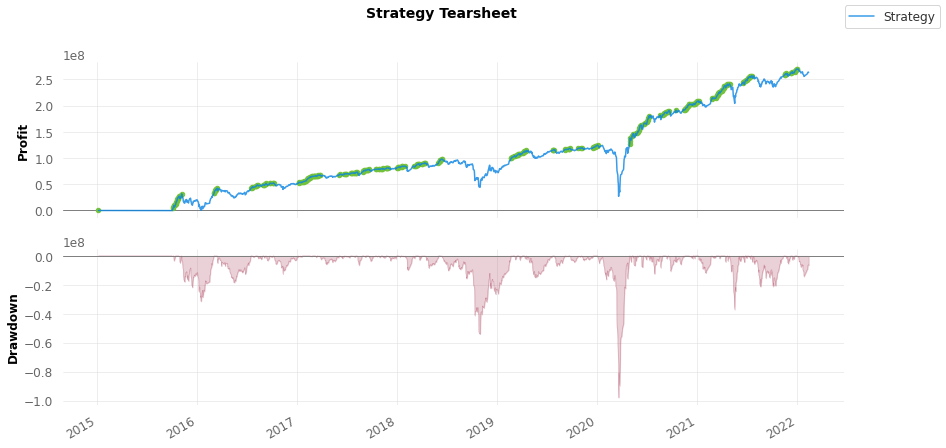

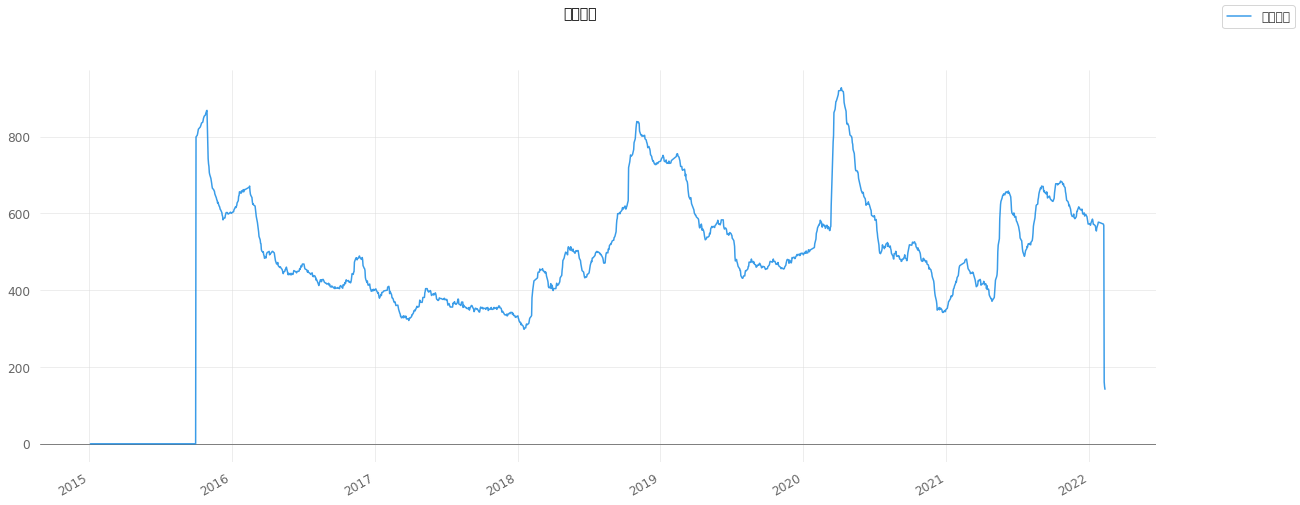

CPU times: total: 1min 12s
Wall time: 1min 15s


In [49]:
%%time
import importlib
%load_ext autoreload
%autoreload 2
importlib.reload(st)

backtest = st.Backtest(df[['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)']], trade_position=trade_position,  stockCash=500000)
report = backtest.run(strategy_map)
# profit = backtest.run(strategy_map)
# report = backtest.getDetailInfo(strategy_map)
profit = backtest.profit

In [50]:
%%time
df_stock = backtest.read_stock()
df_stock

CPU times: total: 4.41 s
Wall time: 4.51 s


,進場張數,不含成本進場價,不含成本出場價,不含成本獲利趴數,進場時間,出場時間,持有天數
證券代碼,,,,,,,
1101 台泥,24.0,20.0586,21.3860,6.617610,2015-10-02,2015-11-09,38.0
1102 亞泥,20.0,24.2676,22.8160,-5.981638,2015-10-02,2015-11-13,42.0
1103 嘉泥,63.0,7.9091,6.9974,-11.527228,2015-10-02,2016-01-26,116.0
1109 信大,58.0,8.5561,8.6412,0.994612,2015-10-02,2015-10-30,28.0
1203 味王,31.0,15.6748,16.9351,8.040294,2015-10-02,2015-10-30,28.0
...,...,...,...,...,...,...,...
5263 智崴,4.0,117.5000,120.0000,2.127660,2022-02-07,2022-02-11,4.0
5471 松翰,5.0,83.6000,85.0000,1.674641,2022-02-07,2022-02-11,4.0
6187 萬潤,4.0,121.0000,129.0000,6.611570,2022-02-07,2022-02-11,4.0


In [ ]:
%%time
# 10張以下占比變化	400以上占比變化	
df['放在最後用'] = 1
strategy_map = {
  '進場': (
    # (df.index.get_level_values(1) == '3035 智原') &
    (df['是否有波段驅使之融資'] == 1) &
    (df['融資是否落底'] == 1) &
    (df['放在最後用'] == 1)
  ),
  '出場': (
    (df['融資是否回升'] == 1) &
    (df[]) &
    (df['放在最後用'] == 1)
  )
}